In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [100]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

In [101]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
from sklearn.preprocessing import OneHotEncoder

In [102]:
def load_dataset(filename):
    df = pd.read_csv(filename, encoding = "latin1", names = ["Sentence", "Intent"])
    print(df.head())
    intent = df["Intent"]
    unique_intent = list(set(intent))
    sentences = list(df["Sentence"])
    return (intent, unique_intent, sentences)

In [103]:
intent, unique_intent, sentences = load_dataset("opencon_dataset_augmented2.csv")


                         Sentence  Intent
0  Is there a bot chatting to me?  GQ.bot
1        Is it automated message?  GQ.bot
2             Computer based pely  GQ.bot
3                   Bot or human?  GQ.bot
4        Bot is chatting with me?  GQ.bot


In [104]:
print(sentences[100:105])
print(unique_intent)

["What's the club about?", 'What does IEEE-VIT does', 'What is IEEE-VIT?', 'What is ieee', 'What is IEEE vit ?']
['SQ.reg_fee', 'GQ.gen', 'FAQ.accom', 'SQ.event_date', 'SQ.event_details', 'GQ.query', 'SQ.event_prize', 'GQ.help', 'FAQ.contact_info', 'FAQ.why_reg', 'SQ.event_speakers', 'JOIN.sponsor', 'JOIN.speaker', 'SQ.reg_lastdate', 'SQ.event_schedule', 'FAQ.food', 'GQ.bot', 'GQ.name', 'SQ.IEEE']


In [105]:
stemmer = LancasterStemmer()  #using lancaster stemmer

In [106]:
def cleaning(sentences):
    words = []
    for s in sentences:
        clean = re.sub(r'[^ a-z A-Z 0-9]', " ", s)
        w = word_tokenize(clean)
        #stemming
        words.append([i.lower() for i in w])
    
    return words  

In [107]:
cleaned_words = cleaning(sentences)
print(len(cleaned_words))

3626


In [108]:
print(cleaned_words[115:118])

[['what', 'is', 'the', 'registration', 'fee', 'of', 'the', 'event'], ['what', 'is', 'the', 'fees', 'required', 'to', 'register', 'for', 'the', 'event'], ['what', 's', 'the', 'price', 'for', 'getting', 'a', 'registration', 'done', 'in', 'the', 'event']]


In [109]:
def create_tokenizer(words, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'):
    token = Tokenizer(filters = filters)
    token.fit_on_texts(words)
    return token

In [110]:
def max_length(words):
    return(len(max(words, key = len)))

In [111]:
word_tokenizer = create_tokenizer(cleaned_words)
vocab_size = len(word_tokenizer.word_index) + 1
max_length = max_length(cleaned_words)

print("Vocab Size = %d and Maximum length = %d" % (vocab_size, max_length))

Vocab Size = 1384 and Maximum length = 27


In [112]:
def encoding_doc(token, words):
    return(token.texts_to_sequences(words))

In [113]:
encoded_doc = encoding_doc(word_tokenizer, cleaned_words)

In [114]:
def padding_doc(encoded_doc, max_length):
    return(pad_sequences(encoded_doc, maxlen = max_length, padding = "post"))

In [115]:
padded_doc = padding_doc(encoded_doc, max_length)

In [116]:
padded_doc[115:118]

array([[  2,   3,   1,  31, 124,  22,   1,   5,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0],
       [  2,   3,   1, 108, 189,   7,  25,   6,   1,   5,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0],
       [  2,  50,   1, 236,   6, 225,  12,  31, 168,  24,   1,   5,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0]])

In [117]:
print("Shape of padded docs = ",padded_doc.shape)

Shape of padded docs =  (3626, 27)


In [118]:
#tokenizer with filter changed
output_tokenizer = create_tokenizer(unique_intent, filters = '!"#$%&()*+,-/:;<=>?@[\]^`{|}~')

In [119]:
output_tokenizer.word_index

{'sq.reg_fee': 1,
 'gq.gen': 2,
 'faq.accom': 3,
 'sq.event_date': 4,
 'sq.event_details': 5,
 'gq.query': 6,
 'sq.event_prize': 7,
 'gq.help': 8,
 'faq.contact_info': 9,
 'faq.why_reg': 10,
 'sq.event_speakers': 11,
 'join.sponsor': 12,
 'join.speaker': 13,
 'sq.reg_lastdate': 14,
 'sq.event_schedule': 15,
 'faq.food': 16,
 'gq.bot': 17,
 'gq.name': 18,
 'sq.ieee': 19}

In [120]:
encoded_output = encoding_doc(output_tokenizer, intent)

In [121]:
encoded_output = np.array(encoded_output).reshape(len(encoded_output), 1)

In [122]:
encoded_output.shape

(3626, 1)

In [123]:
def one_hot(encode):
    o = OneHotEncoder(sparse = False)
    return(o.fit_transform(encode))

In [124]:
output_one_hot = one_hot(encoded_output)

In [125]:
output_one_hot.shape

(3626, 19)

In [126]:
from sklearn.model_selection import train_test_split

In [127]:
x_train, x_val, y_train, y_val = train_test_split(padded_doc, output_one_hot, shuffle = True, test_size = 0.25)
#x_train, x_val, y_train, y_val = train_test_split(padded_doc, output_one_hot, test_size = 0.2, random_state=69)

In [128]:
print("Shape of train_X = %s and train_Y = %s" % (x_train.shape, y_train.shape))
print("Shape of val_X = %s and val_Y = %s" % (x_val.shape, y_val.shape))

Shape of train_X = (2719, 27) and train_Y = (2719, 19)
Shape of val_X = (907, 27) and val_Y = (907, 19)


In [130]:
model=Sequential()
model.add(Embedding(vocab_size, 128, input_length = max_length, trainable = False))
model.add(Bidirectional(LSTM(128)))
#model.add(Dropout(0.5))
model.add(Dense(64, activation = "relu"))    ###
model.add(Dropout(0.5))
model.add(Dense(19, activation = "softmax"))

In [131]:
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])


##may need to define custom optimizer (adam) with low learning rate

In [132]:
filename = 'opencon_model_aug_test2.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#history = model.fit(x_train, y_train, epochs = 100, batch_size = 32, validation_split=0.2, verbose=1, callbacks=[checkpoint])
history = model.fit(x_train, y_train, epochs = 100, batch_size = 20, validation_data= (x_val, y_val), verbose=1,callbacks=[checkpoint])

##trying to reduce batch size and increase epochs to increase val acc

Train on 2719 samples, validate on 907 samples
Epoch 1/100
2620/2719 [===========================>..] - ETA: 0s - loss: 2.9015 - accuracy: 0.0687
Epoch 00001: val_loss improved from inf to 2.80859, saving model to opencon_model_aug_test2.h5
2719/2719 [==============================] - 5s 2ms/sample - loss: 2.8986 - accuracy: 0.0713 - val_loss: 2.8086 - val_accuracy: 0.1047
Epoch 2/100
2580/2719 [===========================>..] - ETA: 0s - loss: 2.6622 - accuracy: 0.1581
Epoch 00002: val_loss improved from 2.80859 to 2.40900, saving model to opencon_model_aug_test2.h5
2719/2719 [==============================] - 1s 450us/sample - loss: 2.6475 - accuracy: 0.1592 - val_loss: 2.4090 - val_accuracy: 0.2624
Epoch 3/100
2580/2719 [===========================>..] - ETA: 0s - loss: 2.2342 - accuracy: 0.2911
Epoch 00003: val_loss improved from 2.40900 to 1.99832, saving model to opencon_model_aug_test2.h5
2719/2719 [==============================] - 1s 445us/sample - loss: 2.2291 - accuracy: 0.2

Epoch 27/100
2660/2719 [============================>.] - ETA: 0s - loss: 0.3181 - accuracy: 0.9068
Epoch 00027: val_loss did not improve from 0.26801
2719/2719 [==============================] - 1s 469us/sample - loss: 0.3147 - accuracy: 0.9077 - val_loss: 0.4944 - val_accuracy: 0.8754
Epoch 28/100
2660/2719 [============================>.] - ETA: 0s - loss: 0.2113 - accuracy: 0.9429
Epoch 00028: val_loss improved from 0.26801 to 0.24207, saving model to opencon_model_aug_test2.h5
2719/2719 [==============================] - 1s 466us/sample - loss: 0.2113 - accuracy: 0.9430 - val_loss: 0.2421 - val_accuracy: 0.9305
Epoch 29/100
2620/2719 [===========================>..] - ETA: 0s - loss: 0.1681 - accuracy: 0.9519
Epoch 00029: val_loss improved from 0.24207 to 0.23525, saving model to opencon_model_aug_test2.h5
2719/2719 [==============================] - 1s 442us/sample - loss: 0.1667 - accuracy: 0.9533 - val_loss: 0.2353 - val_accuracy: 0.9394
Epoch 30/100
2620/2719 [================

Epoch 54/100
2640/2719 [============================>.] - ETA: 0s - loss: 0.0765 - accuracy: 0.9803
Epoch 00054: val_loss did not improve from 0.14814
2719/2719 [==============================] - 1s 438us/sample - loss: 0.0769 - accuracy: 0.9794 - val_loss: 0.1953 - val_accuracy: 0.9515
Epoch 55/100
2580/2719 [===========================>..] - ETA: 0s - loss: 0.1128 - accuracy: 0.9709
Epoch 00055: val_loss did not improve from 0.14814
2719/2719 [==============================] - 1s 449us/sample - loss: 0.1101 - accuracy: 0.9717 - val_loss: 0.2121 - val_accuracy: 0.9548
Epoch 56/100
2620/2719 [===========================>..] - ETA: 0s - loss: 0.0527 - accuracy: 0.9863
Epoch 00056: val_loss did not improve from 0.14814
2719/2719 [==============================] - 1s 459us/sample - loss: 0.0520 - accuracy: 0.9868 - val_loss: 0.2206 - val_accuracy: 0.9570
Epoch 57/100
2620/2719 [===========================>..] - ETA: 0s - loss: 0.0632 - accuracy: 0.9874
Epoch 00057: val_loss did not improv

In [133]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 27, 128)           177152    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 19)                1235      
Total params: 458,003
Trainable params: 280,851
Non-trainable params: 177,152
_________________________________________________________________


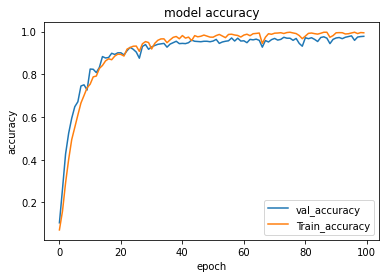

In [134]:
def plotloss(history):
    plt.plot(history.history['val_accuracy'])
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['val_accuracy', 'Train_accuracy'], loc = 'lower right')
    plt.show()
    
plotloss(history)

In [135]:
_,acc=model.evaluate(x_val,y_val)
print(acc*100)

907/907 [==============================] - 0s 159us/sample - loss: 0.1259 - accuracy: 0.9779
97.79492616653442


In [136]:
model = load_model("opencon_model_aug_test2.h5")

In [137]:
def predictions(text):
    clean = re.sub(r'[^ a-z A-Z 0-9]', " ", text)
    test_word = word_tokenize(clean)
    test_word = [w.lower() for w in test_word]
    test_ls = word_tokenizer.texts_to_sequences(test_word)
    #print(test_word)            ##
    #Check for unknown words
    if [] in test_ls:
        test_ls = list(filter(None, test_ls))
    
    test_ls = np.array(test_ls).reshape(1, len(test_ls))
 
    x = padding_doc(test_ls, max_length)
  
    pred = model.predict_proba(x)
  
    return pred 

In [138]:
def get_final_output(pred, classes):
    predictions = pred[0]
 
    classes = np.array(classes)
    ids = np.argsort(-predictions)
    classes = classes[ids]
    predictions = -np.sort(-predictions)
    pred_intent=classes[0]
 
    #for i in range(pred.shape[1]):
        #print("%s has confidence = %s" % (classes[i], (predictions[i])))
    return pred_intent


In [ ]:
'''
text="need some help?"
pred = predictions(text)

#predictions(text)
get_final_output(pred, unique_intent)
#word = word_for_id(pred, output_tokenizer)

'''

In [139]:
A_GQ_help = ["Yes, I can help you with anything.", "What do you need help with?", "Sure. What can I help you with?"]
A_FAQ_why_reg = ["Because there's no other event like this", "you will learn many new things", 
             " No other event which has both conference and hackathon"]
A_SQ_IEEE = ["IEEE-VIT is one of the most active and prestigious chapters of VIT", "IEEE-VIT is a student technical chapter",
             "IEEE-VIT is a student based chapter which falls under region 10"]
A_SQ_reg_fee = ["No, the event is free to attend", "There is no registration fee for the event", "No, the registrations are free"]
A_GQ_name = ["My name is IEEE bot", " I am IEEE bot", "You are talking to IEEE bot"]
A_FAQ_food = ["Yes, food will be provided","Yes, refreshments will be provided","Sure, everyone needs food"]
A_GQ_query =[ "Yes, go ahead","Ask me any queries you have","go ahead, ask away"]
A_GQ_bot = ["That's right, I am a chatbot", "Yes, I am a chatbot", "I am a bot. Chatbot"]
A_SQ_event_details = ["This event is all about learning", "It's a hackathon","It's a fun event for sure"]
A_GQ_gen = ["I am good","I am doing great","Never better"]
A_SQ_event_prize = ["Yes, there will be prizes","Definitely","Yes there will be, along with goodies"]
A_FAQ_contact_info = ["Please contact us via insta","We are reachable from our insta handle","You can contact us anytime via insta"]
A_JOIN = ["Please contact us via collaborations.ieeevit@gmail.com, thank you."]
A_SQ_event_speakers=["speaker 1 and 2 will join us, stay tuned for more"," We have confirmed speaker 1 and 2"]
A_SQ_event_date=["From 10th to 12th","It will be for 2 days starting from 10th","10th-12th"]
A_SQ_reg_lastdate=["The last day to register is 9th","You can register by 9th","9th is the last day to register"]
A_SQ_event_schedule=["There will be talks followed by a hackthon","First talks then hack","Hack after speech"]
A_FAQ_accom=["No, accomodation can't be provided","Sorry, we dont provide accomodation","There is no accomodation facility from our side"]



In [140]:
import random
def F1():
    print('bot: ',random.choice(A_GQ_help))
def F2():
    print('bot: ',random.choice(A_FAQ_why_reg))
def F3():
    print('bot: ',random.choice(A_SQ_IEEE))
def F4():
    print('bot: ',random.choice(A_SQ_reg_fee))
def F5():
    print('bot: ',random.choice(A_GQ_name))
def F6():
    print('bot: ',random.choice(A_FAQ_food))
def F7():
    print('bot: ',random.choice(A_GQ_query))
def F8():
    print('bot: ',random.choice(A_GQ_bot))
def F9():
    print('bot: ',random.choice(A_SQ_event_details))
def F10():
    print('bot: ',random.choice(A_GQ_gen))
def F11():
    print('bot: ',random.choice(A_SQ_event_prize))
def F12():
    print('bot: ',random.choice(A_FAQ_contact_info))
def F13():
    print('bot: ',random.choice(A_JOIN))
def F14():
    print('bot: ',random.choice(A_SQ_event_speakers))
def F15():
    print('bot: ',random.choice(A_SQ_event_date))
def F16():
    print('bot: ',random.choice(A_SQ_reg_lastdate))
def F17():
    print('bot: ',random.choice(A_SQ_event_schedule))
def F18():
    print('bot: ',random.choice(A_FAQ_accom))

In [141]:
def user_output():
    for i in range(100):
        text=input('\nYou: ')
        if text == 'quit':
            print('bye')
            break
        else : 
            pred = predictions(text)
            if get_final_output(pred, unique_intent) == 'GQ.help':
                F1()
            elif get_final_output(pred, unique_intent) == 'FAQ.why_reg':
                F2()
            elif get_final_output(pred, unique_intent) == 'SQ.IEEE':
                F3()
            elif get_final_output(pred, unique_intent) == 'SQ.reg_fee':
                F4()
            elif get_final_output(pred, unique_intent) == 'GQ.name':
                F5()
            elif get_final_output(pred, unique_intent) == 'FAQ.food':
                F6()
            elif get_final_output(pred, unique_intent) == 'GQ.query':
                F7()
            elif get_final_output(pred, unique_intent) == 'GQ.bot':
                F8()
            elif get_final_output(pred, unique_intent) == 'SQ.event_details':
                F9()
            elif get_final_output(pred, unique_intent) == 'GQ.gen':
                F10()
            elif get_final_output(pred, unique_intent) == 'SQ.event_prize':
                F11()
            elif get_final_output(pred, unique_intent) == 'FAQ.contact_info':
                F12()
            elif get_final_output(pred, unique_intent) == 'JOIN.speaker':
                F13()
            elif get_final_output(pred, unique_intent) == 'JOIN.sponsor':
                F13()
            elif get_final_output(pred, unique_intent) == 'SQ.event_speakers':
                F14()
            elif get_final_output(pred, unique_intent) == 'SQ.event_date':
                F15()
            elif get_final_output(pred, unique_intent) == 'SQ.reg_lastdate':
                F16()
            elif get_final_output(pred, unique_intent) == 'SQ.event_schedule':
                F17()
            elif get_final_output(pred, unique_intent) == 'FAQ.accom':
                F18()
            else:
                print("Please enter a valid response")



In [142]:
user_output()


You: I want to speak
bot:  Please contact us via collaborations.ieeevit@gmail.com, thank you.

You: last date to register?
bot:  You can register by 9th

You: what about refreshments?
bot:  Yes, refreshments will be provided

You: quit
bye
